In [46]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from skimage.transform import iradon

In [47]:
%matplotlib inline

In [48]:
def recolour_image(before, bgr=[1.5, 0.75, 1.25]):
    """
    Recolour greyscale image `before` to new colour `bgr`
    in blue-green-red format
    
    Adapted from: https://stackoverflow.com/a/58142700
    """
    
    before = cv2.cvtColor(before, cv2.COLOR_GRAY2BGR)
    b, g, r = cv2.split(before)

    np.multiply(b, bgr[0], out=b, casting="unsafe")
    np.multiply(g, bgr[1], out=g, casting="unsafe")
    np.multiply(r, bgr[2], out=r, casting="unsafe")

    after = cv2.merge([b, g, r])
    
    return after


def split_images(im):
    """
    Return first and mid-point images from stack
    """
    
    return im[0], im[int(len(im)/2)]


def overlay_images(img1, img2, translation):
    """
    Recolour two greyscale images to red and green,
    flip second image,
    overlay with 50% transparency
    """
    
    M = np.float32([
        [1, 0, translation],
        [0, 1, 0]
    ])
    
    img_0 = recolour_image(img1, bgr=[0, 0, 255])
    img_180 = np.fliplr(recolour_image(img2, bgr=[0, 255, 0]))
    img_180_shift = cv2.warpAffine(img_180, M, (img_180.shape[1], img_180.shape[0]))
    blended = cv2.addWeighted(img_0, 0.5, img_180_shift, 0.5, 0.0)
    blended = cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)
    
    return blended


def subtract_images(img1, img2, translation):
    """
    Translate second image relative to first, and subtract
    """
    
    M = np.float32([
        [1, 0, translation],
        [0, 1, 0]
    ])
    
    img2 = np.fliplr(img2)
    img_180_shift = cv2.warpAffine(img2, M, (img2.shape[1], img2.shape[0]))
    subtracted = cv2.subtract(img1, img_180_shift)
    
    return subtracted


def misalignment(img1, img2, offset):
    """
    Return sum of intensity in central half of difference 
    between two images, as measure of misalignment
    """
    
    x = subtract_images(img1, img2, offset)
    width = np.shape(x)[1]
    intensity = np.concatenate(x[:,width//4:width*3//4]).sum()
    
    return intensity


def align_images(img1, img2):
    """
    Slide two images past each other and find offset which minimises misalignment
    """
    
    width = img1.shape[1]
    frac = 4  # decreasing factor tries larger range of offsets
    offsets = np.arange(-width//frac, width//frac)  # working with integer offsets only
    misalignments = [misalignment(img1, img2, i) for i in tqdm(offsets)]
    stack = np.column_stack((offsets, misalignments))
    optimal = stack[np.argmin(stack[:, 1]), 0]
    
    return optimal


def plot_alignment(im):
    """
    Split image, align front and back projections, and plot
    """
    
    img1, img2 = split_images(im)
    optimal = align_images(img1, img2)
    f, axes = plt.subplots(1,2)
    axes[0].imshow(overlay_images(img1, img2, 0).astype(np.uint8))  # rescale to [0,255]
    axes[0].set_title('Original')
    axes[1].imshow(overlay_images(img1, img2, optimal).astype(np.uint8))
    axes[1].set_title(f'Aligned (offset {int(optimal)} px)')
    plt.show()
    

def apply_offset(im):
    """
    Cut `offset` pixels from side of all images in z-stack
    to recentre axis of rotation
    """

    img1, img2 = split_images(im)
    optimal = align_images(img1, img2)
    
    M = np.float32([
        [1, 0, -optimal/2],
        [0, 1, 0]
    ])
    
    corrected = np.array([cv2.warpAffine(slce, M, (slce.shape[1], slce.shape[0])) for slce in tqdm(im)])
    
    return corrected
    

def recon(im):
    """
    Reconstruct tomographic image using inverse radon transform
    """
    theta = np.linspace(0, 360, np.shape(im)[0], endpoint=False)
    sinogram = np.moveaxis(im, 0, -1)

    reconstruction_fbp = np.zeros((im.shape[1], im.shape[2], im.shape[2]))
    for i in tqdm(range(im.shape[1])):
        reconstruction_fbp[i] = iradon(sinogram[i], theta=theta, filter_name='ramp')
    
    return reconstruction_fbp


def recon_part(im, frac=0.5):
    """
    Reconstruct part of tomographic image using inverse radon transform
    """
    theta = np.linspace(0, 360, np.shape(im)[0], endpoint=False)
    sinogram = np.moveaxis(im, 0, -1)

    reconstruction_fbp = np.zeros((int(im.shape[1]*frac), im.shape[2], im.shape[2]))
    for i in tqdm(range(int(im.shape[1]*frac))):
        reconstruction_fbp[i] = iradon(sinogram[i], theta=theta, filter_name='ramp')
    
    return reconstruction_fbp

    
def disp_slices(reconstructed):
    """
    Display 4 slices through reconstructed image
    """
    
    f, axes = plt.subplots(2,2)
    slices = len(reconstructed)
    axes[0][0].imshow(reconstructed[0], cmap='gray')
    axes[0][1].imshow(reconstructed[slices//4], cmap='gray')
    axes[1][0].imshow(reconstructed[slices//2], cmap='gray')
    axes[1][1].imshow(reconstructed[(slices*3)//4], cmap='gray')
    plt.show()

In [49]:
# needle_resized = io.imread('../../data_store/2022-10-10_1433_testrecon/2022-10-10_1433_testrecon_result.tif')
# plot_alignment(needle_resized)

In [50]:
# needle_resized_aligned = apply_offset(needle_resized)

In [51]:
# reconstructed = recon(needle_resized)
# np.save('needle_resized_reconstructed', reconstructed)

In [52]:
# reconstructed = np.load('needle_resized_reconstructed.npy')
# disp_slices(reconstructed)

In [53]:
# reconstructed = recon(needle_resized_aligned)
# np.save('needle_resized_aligned_reconstructed', reconstructed)

In [54]:
# reconstructed = np.load('needle_resized_aligned_reconstructed.npy')
# disp_slices(reconstructed)

In [55]:
# needle_full = io.imread('../../data_store/2022-10-10_1433_testrecon/2022-10-10_1433_testrecon.tif')
# plot_alignment(needle_full)

In [56]:
# mouse = io.imread('../../data_store/MSc_OPT_testdata/misaligned/misaligned.tif')
# plot_alignment(mouse)

In [57]:
# mouse_aligned = apply_offset(mouse)

In [58]:
# reconstructed = recon(mouse)
# np.save('mouse_reconstructed', reconstructed)

In [59]:
# reconstructed = np.load('mouse_reconstructed.npy')
# disp_slices(reconstructed)

In [60]:
# reconstructed = recon(mouse_aligned)
# np.save('mouse_aligned_reconstructed', reconstructed)

In [61]:
# reconstructed = np.load('mouse_aligned_reconstructed.npy')
# disp_slices(reconstructed)

100%|██████████| 260/260 [00:00<00:00, 262.54it/s]


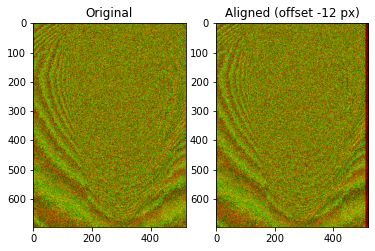

In [62]:
fluorescent = io.imread('../../data_store/2022-11-24 fluorescence phantom/1_1_MMStack_Pos0-resized.ome.tif')
plot_alignment(fluorescent)

In [63]:
fluoro_aligned = apply_offset(fluorescent)

100%|██████████| 400/400 [00:01<00:00, 353.29it/s]


In [64]:
reconstructed = recon_part(fluorescent, frac=0.05)
np.save('fluoro_reconstructed', reconstructed)

100%|██████████| 34/34 [00:47<00:00,  1.39s/it]


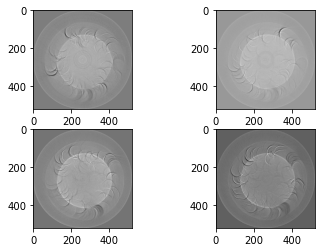

In [65]:
reconstructed = np.load('fluoro_reconstructed.npy')
disp_slices(reconstructed)